In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#from tqdm import tqdm
import datetime as dt  # datetime handling
import json
import tensorflow_addons as tfa

import tensorflow as tf
import sys
import tqdm  # progress bars
import nltk.translate.bleu_score as ntbs  # BLEU scoring basics

# Install packages
!pip install rouge-score

import rouge_score.rouge_scorer as rouge_scorer  # ROUGE scoring basics


In [37]:
MODEL_NAME = 'WordVecs_Train_Test'

FP_CAPTIONS = '../input/flickr8k/captions.txt'
DIR_IMAGES = '../input/flickr8k/Images/'
DIR_IMAGE_FEATURES = '../input/aida-image-captioning/Images/'
DIR_MODEL_STORE = './models/'
DIR_MODEL_LOG = './models/'
DIR_RESULT_STORE = './results/'
DIR_TENSORBOARD_LOG = './tensorboard/'
EARLY_STOPPING_PATIENT = 10
timestamp_str = None

In [10]:
!mkdir results
!mkdir models    
!mkdir tensorboard
!mkdir models/$MODEL_NAME

# Load word vectors

In [11]:
import pickle

embeddings_index = pickle.load(  open( "../input/aida-image-captioning-preprocessing-glove/embeddings_index.p", "rb" ) )

In [12]:
values_view = embeddings_index.values()
value_iterator = iter(values_view)
first_value = next(value_iterator)

wv_size = first_value.shape[0]

# Test Data

In [13]:
df_cap = pd.read_csv('../input/flickr8k/captions.txt')
df_cap.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [14]:
# check number captions per image
df_cap.groupby('image').agg(cap_count=('caption','count')).describe()

,cap_count
count,8091.0
mean,5.0
std,0.0
min,5.0
25%,5.0
50%,5.0
75%,5.0
max,5.0


In [15]:
# test if images are there for every entry
img_file_not_exist = []

IMAGES_BASE = '../input/flickr8k/Images'
for image in df_cap['image'].unique():
    if not os.path.exists(os.path.join(IMAGES_BASE, image)):
        img_file_not_exist.append(image)
    
print(f'Number of image files not exists in "{IMAGES_BASE}" directory: {len(img_file_not_exist)}')

Number of image files not exists in "../input/flickr8k/Images" directory: 0


In [16]:
# test if images features are there for every entry
img_file_not_exist = []

IMAGE_FEATURES_BASE = '../input/aida-image-captioning/Images'
for image in df_cap['image'].unique():
    if not os.path.exists(os.path.join(IMAGE_FEATURES_BASE, image.replace('.jpg', '.npy'))):
        img_file_not_exist.append(image)
    
print(f'Number of image feature files not exists in "{IMAGE_FEATURES_BASE}" directory: {len(img_file_not_exist)}')

Number of image feature files not exists in "../input/aida-image-captioning/Images" directory: 0


# Preprocess Captions

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preproc_text(texts):
    """
    - Adds <start> to the beginning of texts to the inputs
    - Adds <end> to
    Input: texts: list of sentences
    Output: - tokenized, padded text with <start> token for using as input in decoder
            - tokenized, padded text with <end> token for using as target in decoder
            - tokenizer
            - max_seq_len
    """
    
    print('Creating and fitting tokenizer...')
    tokenizer_fit_data = ['<start> ' + s + ' <end>' for s in texts]

    # create tokenizer for captions + <start> and <end> tags
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(tokenizer_fit_data)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    print('Creating and fitting tokenizer done')
    
    print('Create text input sequences...')
    # add <start> tag before every caption and tokenize + pad ('post')
    enc_input_data = ['<start> ' + s for s in texts]
    enc_input_token_seqs = tokenizer.texts_to_sequences(enc_input_data)
    # if no "maxlen" defined then pad_sequences takes the longest sequence as max_len
    enc_input_prep = pad_sequences(enc_input_token_seqs, padding='post')
    print('Create text input sequences done')
    
    print('Create text target sequences...')
    # add <start> tag before every caption and tokenize + pad ('post')
    enc_target_data = [s + ' <end>' for s in texts]
    enc_target_token_seqs = tokenizer.texts_to_sequences(enc_target_data)
    # if no "maxlen" defined then pad_sequences takes the longest sequence as max_len
    enc_target_prep = pad_sequences(enc_target_token_seqs, padding='post')
    print('Create text target sequences done')
    
    print('\n\n')
    
    # show some texts processed
    for i  in range(2):
        print(f'               {i} orig: {texts[i]}')
        print(f'              {i} input: {enc_input_data[i]}')
        print(f' {i} preprocessed input: {enc_input_prep[i]}')
        print(f'             {i} target: {enc_target_data[i]}')
        print(f'{i} preprocessed target: {enc_target_prep[i]}')
        print()

    print('\n\n')
    print(f' preprocessed input shape: {enc_input_prep.shape}')
    print(f'preprocessed target shape: {enc_target_prep.shape}')
    
    return enc_input_prep, enc_target_prep, tokenizer, enc_input_prep.shape[-1]  # last dim is the length of the sequences        

In [18]:
enc_input_prep, enc_target_prep, tokenizer, max_seq_len = preproc_text(df_cap['caption'].values)

Creating and fitting tokenizer...
Creating and fitting tokenizer done
Create text input sequences...
Create text input sequences done
Create text target sequences...
Create text target sequences done



               0 orig: A child in a pink dress is climbing up a set of stairs in an entry way .
              0 input: <start> A child in a pink dress is climbing up a set of stairs in an entry way .
 0 preprocessed input: [   2    1   43    4    1   90  172    7  119   51    1  393   12  394
    4   28 5159  670    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
             0 target: A child in a pink dress is climbing up a set of stairs in an entry way . <end>
0 preprocessed target: [   1   43    4    1   90  172    7  119   51    1  393   12  394    4
   28 5159  670    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]

               1 orig: A girl going into a wooden building .

In [19]:
vocab_size =  len(tokenizer.word_index) 
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, wv_size))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(8495, 300)

# Create Train-Test Split

In [20]:
from sklearn.model_selection import train_test_split

# create 80,20 % split on the images
_, test_img_names = train_test_split(df_cap['image'].unique(), test_size=0.2, random_state=42)

df_cap['is_test'] = df_cap['image'].isin(test_img_names)

df_cap.head(2)

,image,caption,is_test
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,False
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,False


In [21]:
train_enc_input_prep = enc_input_prep[df_cap[~df_cap['is_test']].index]
train_enc_target_prep = enc_target_prep[df_cap[~df_cap['is_test']].index]

test_enc_input_prep = enc_input_prep[df_cap[df_cap['is_test']].index]
test_enc_target_prep = enc_target_prep[df_cap[df_cap['is_test']].index]

train_image_feature_names = df_cap[~df_cap['is_test']]['image'].map(lambda x: os.path.join(IMAGE_FEATURES_BASE, x.replace('.jpg', '.npy'))).values
test_image_feature_names = df_cap[df_cap['is_test']]['image'].map(lambda x: os.path.join(IMAGE_FEATURES_BASE,x.replace('.jpg', '.npy'))).values

In [22]:
# show train_image_features
train_image_feature_names.shape, train_image_feature_names[:2]

((32360,),
 array(['../input/aida-image-captioning/Images/1000268201_693b08cb0e.npy',
        '../input/aida-image-captioning/Images/1000268201_693b08cb0e.npy'],
       dtype=object))

# Create Train-Test Datasets for Tensorflow

__Currently doesn't work, continue with *Create Data Generator* (next section)__

In [23]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.index_word)

print(f'vocab size: {VOCAB_SIZE}')

vocab size: 8495


In [24]:
# Load the numpy files
def map_func(img_name, cap_inp, cap_targ):
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    img_tensor = np.load(img_name)
    return img_tensor, cap_inp, cap_targ

In [25]:
# train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_feature_names, train_enc_input_prep, train_enc_target_prep))
#train_dataset = tf.data.Dataset.from_tensor_slices(({"input_1": train_image_feature_names, "input_2": train_enc_input_prep}, train_enc_target_prep))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
data = next(iter(train_dataset))

In [27]:
type(data), len(data)

(tuple, 3)

In [28]:
# test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_feature_names, test_enc_input_prep, test_enc_target_prep))

# Use map to load the numpy files in parallel
test_dataset = train_dataset.map(lambda item1, item2, item3: tf.numpy_function(
          map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Do not shuffle
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Create Data Generator

In [29]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_names, cap_inputs, cap_targets, batch_size, shuffle=True):
        self.image_names = image_names
        self.cap_inputs = cap_inputs
        self.cap_targets = cap_targets
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_names))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return int(np.floor(len(self.image_names) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        imgs, cap_ins, cap_outs = [], [], []
        
        for i in indexes:
            imgs.append( np.load(self.image_names[i]) )
            cap_ins.append( self.cap_inputs[i] )
            cap_outs.append( self.cap_targets[i] )
        
        return (np.array(imgs), np.array(cap_ins)),  np.array(cap_outs)

In [30]:
BATCH_SIZE = 64
EMBEDDING_DIM = 256
UNITS = 2048#512
VOCAB_SIZE = len(tokenizer.index_word)

train_gen = MyDataGenerator(train_image_feature_names, train_enc_input_prep, train_enc_target_prep, batch_size=BATCH_SIZE, shuffle=True)
test_gen = MyDataGenerator(test_image_feature_names, test_enc_input_prep, test_enc_target_prep, batch_size=BATCH_SIZE, shuffle=False)

# Create Enc-Dec Model

In [31]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

In [32]:
def create_base_enc_dec_model(enc_input_shape, output_seq_length, embedding_dim, vocab_size, units):
    # ENCODER
    enc_input = Input(shape=enc_input_shape, name='enc_input')   
    #enc_output= layers.GlobalAveragePooling2D()(enc_input)
    enc_output = layers.Flatten()(enc_input) # BSx64x2048 => BSx131072
    enc_output = layers.Dense(units, activation='relu', name='enc_output')(enc_output)    

    # DECODER
    # dec_input = Input(shape=(output_seq_length,), name='dec_input')    
    dec_input = Input(shape=(None,), name='dec_input')    
    #dec_embed_out = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='dec_embed')(dec_input)
    dec_embed_out = layers.Embedding(vocab_size, wv_size, weights=[embedding_matrix], trainable=False, name='dec_embed')(dec_input) #input_length=max_seq_len, 
    
    dec_lstm_out, _, _ = layers.LSTM(units, return_sequences=True, return_state=True,name= 'dec_lstm')(dec_embed_out, initial_state=[enc_output, enc_output])
    dec_out = layers.Dense(vocab_size, activation='softmax', name='dec_dense')(dec_lstm_out)
    
    # create own loss function
    # means: mask out padded targets
    def loss_func(targets, preds):
        # last layer has softmax activation => from_logits=False
        #sparse_cat_ce = SparseCategoricalCrossentropy()
        sparse_cat_ce = SparseCategoricalCrossentropy(from_logits=True)
        mask = K.cast(K.greater(targets, 0), dtype=tf.int64)    
        # calc cross entropy masked
        loss = sparse_cat_ce(targets, preds, sample_weight=mask)
        return loss

    def accuracy_func(targets, preds):
        real_preds = K.cast(K.argmax(preds, axis=-1), dtype=tf.float32)
        correct = K.cast(K.equal(targets, real_preds), dtype=tf.float32)
        # mask out 0 padded elements
        mask = K.cast(K.greater(targets, 0), dtype=tf.float32)
        n_correct = K.sum(mask * correct)
        n_total = K.sum(mask)
        return n_correct/n_total
    
    model = Model([enc_input, dec_input], dec_out)

    model.compile(
        optimizer=Adam(learning_rate=1e-4, clipnorm=5.0),
        loss=loss_func,
        metrics=[accuracy_func]        
    )

    return model

In [33]:
model = create_base_enc_dec_model(
    enc_input_shape=(64, 2048), 
    output_seq_length=enc_input_prep.shape[-1], 
    embedding_dim=EMBEDDING_DIM,
    vocab_size=VOCAB_SIZE,
    units=UNITS)    

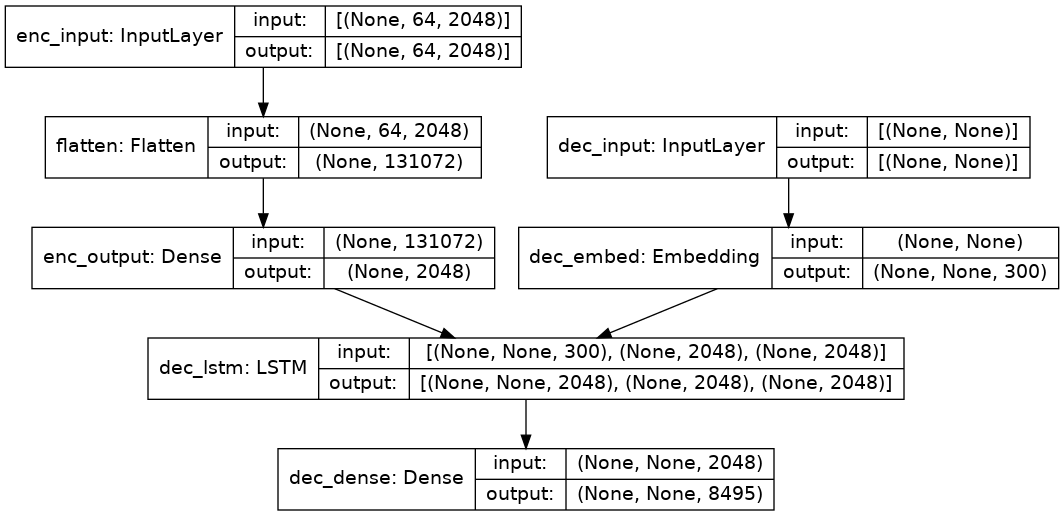

In [34]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

In [35]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#history = model.fit(train_gen, epochs=100, validation_data=test_gen, callbacks=[callback])

In [42]:
# Define callbacks
checkpoint_filepath = DIR_MODEL_STORE + 'checkpoint'
cb_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy_func',
    mode='max',
    save_best_only=True)
cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=EARLY_STOPPING_PATIENT)
cb_tqdm = tfa.callbacks.TQDMProgressBar()
if True: #LOG_MODEL:
    cb_tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir = DIR_TENSORBOARD_LOG + f"{model.name}_{timestamp_str}",
        histogram_freq=0, update_freq='epoch',
        write_graph=True, write_images=False)
    callbacks = [cb_early_stopping, cb_tqdm, cb_tensorboard, cb_checkpoint]
else:
    callbacks = [cb_early_stopping, cb_tqdm, cb_checkpoint]

# Plot model
if True: #SAVE_MODEL:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
    plot_model(model, 
           show_shapes=True, 
           to_file=DIR_MODEL_STORE + model.name + "_" + timestamp_str + ".png")
else:
    plot_model(model, show_shapes=True)

EPOCHS=50
# Train model
if True:
    history = model.fit(
        train_gen,
        epochs=EPOCHS, 
        validation_data=test_gen, 
        callbacks=callbacks,
        verbose=0)

    # Save model and history
    if True: #SAVE_MODEL:
        # Save history
        fp_hist = DIR_MODEL_STORE + model.name + "_" + timestamp_str + ".pickle"
        save_hist(fp_hist, history)
        print(f"Model history for {model.name} saved to: {fp_hist}")

        # Save model
        fp_model = DIR_MODEL_STORE + model.name + "_" + timestamp_str + ".h5"
        model.save(fp_model, save_format='h5')
        print(f"Model {model.name} saved to: {fp_model}")

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/505           ETA: ?s - 

KeyboardInterrupt: 

In [ ]:
trained_model_fname = 'trained_model_wv.model'
model.save(trained_model_fname)

# Create prediction models

In [ ]:
# create prediction models from trained model
def crea_prediction_models(model, units):    
    # ENCODER
    enc_input = model.get_layer(name='enc_input').input   
    enc_output = model.get_layer(name='enc_output').output
    encoder_model = Model(enc_input, [enc_output, enc_output])  # I take the same for hidden state and cell state
        
    # DECODER
    # 1. define Inputs (LSTM => (hidden_state, cell_state))
    dec_input = model.get_layer(name='dec_input').input
    dec_state_input_h = Input(shape=(units,))
    dec_state_input_c = Input(shape=(units,))
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    
    # 2. get embedding layer
    dec_embedding = model.get_layer(name='dec_embed')
    dec_outputs = dec_embedding(dec_input)
    
    # 3. get LSTM     
    # initial_state comes from encoder in first time step after that from last times hidden+cell state
    dec_lstm = model.get_layer(name='dec_lstm')  
    dec_outputs, state_h_dec, state_c_dec = dec_lstm(
        dec_outputs, initial_state=dec_states_inputs
    )
  
    # 4. output FC layer
    dec_dense = model.get_layer(name='dec_dense')
    dec_outputs = dec_dense(dec_outputs)
    
    # 5. Create Model
    decoder_model = Model(
        [dec_input, dec_state_input_h, dec_state_input_c],
        [dec_outputs, state_h_dec, state_c_dec] # give out hidden state for next iteration
    )
    
    return encoder_model, decoder_model

encoder_model, decoder_model = crea_prediction_models(model, units=UNITS)

In [ ]:
MAX_DECODER_SEQ_LEN = enc_input_prep.shape[-1]

def make_predict(input_img_feature_path):
    #
    # input_img_feature_path: path to picture features numpy data
    
    # load numpy features from input_img_feature_path
    img_features = np.expand_dims( np.load(input_img_feature_path), axis=0 )
    
    # get encoder states
    state_h, state_c = encoder_model.predict(img_features)
    
    #print('state_h, state_c .shape', state_h.shape, state_c.shape)
    
    # create start token    
    dec_input = tf.constant([[tokenizer.word_index['<start>']]])
    #print('dec_input.shape', dec_input.shape)
    
    caption = []
    
    while len(caption) < MAX_DECODER_SEQ_LEN:
        dec_output, state_h, state_c = decoder_model.predict(
            [dec_input, state_h, state_c]
        )
        
        # next input must be the current output (this is already a word index)
        dec_input = tf.argmax(dec_output, -1)

        word_ndx = dec_input.numpy()[0,0] # detach from tf
        predicted_word = tokenizer.index_word[word_ndx]
        
        # do not append <end> tag to caption
        if predicted_word == '<end>':
           break
        
        caption.append(predicted_word)
            
    return ' '.join(caption)

In [ ]:
import matplotlib.pyplot as plt

def eval_image_from_test(img_name):
    img = plt.imread(os.path.join(IMAGES_BASE, img_name))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.show()
    
    print(f'\nReference captions:\n{"-"*80}')
    for l in df_cap[df_cap['image']==img_name]['caption'].values:
        print(f'- {l}')
    
    prediction = make_pr# Prepare true captures (references) and predicted captures (candidates)
c_true_train = dict()
c_pred_train = dict()
df = df_cap.loc[df_cap.is_test == False]
for img_fname in tqdm.tqdm_notebook(df.image.unique(), total=len(df.image.unique())):
    c_true_train[img_fname] = df_cap.loc[df_cap.image == img_fname].caption.to_list()
    c_pred_train[img_fname] = make_predict(os.path.join(IMAGE_FEATURES_BASE, img_fname.replace('.jpg','.npy')))

# Serialize data into file
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
json.dump(c_true_train, open(DIR_RESULT_STORE + f"c_true_train_{timestamp_str}.json", 'w'))
json.dump(c_pred_train, open(DIR_RESULT_STORE + f"c_pred_train_{timestamp_str}.json", 'w'))

# Calculate Metrics
rouge_l_train, bleu_1_train = met.evaluate(c_true_train, c_pred_train)
print(f"Metrics for Trainset:\nROUGE-L recall:{rouge_l_train:>10.2%}\nBLEU-1 precision: {bleu_1_train:>7.2%}")edict(os.path.join(IMAGE_FEATURES_BASE, img_name.replace('.jpg','.npy')))
    print(f'\nPrediction:\n{"-"*80}')
    print(f'- {prediction}')

# Predict something from test

In [ ]:
num_predictions = 10
for img_file_name in df_cap[df_cap['is_test']].sample(num_predictions)['image'].values:
    eval_image_from_test(img_file_name)
    print(f'{"="*80}\n')    

## Calc ROUGE-L and BLEU-1 metrics

In [ ]:
sys.path.insert(0, '../input/aida-metrics-functions')  # custom metrics implementation
import metrics as met  # custom metrics BLUE-1 pecsision and ROUGE-L recall


In [ ]:
DIR_RESULT_STORE = './results/'
!mkdir $DIR_RESULT_STORE

### Testset

In [ ]:
# Prepare true captures (references) and predicted captures (candidates)
c_true_test = dict()
c_pred_test = dict()
df = df_cap.loc[df_cap.is_test == True]
for img_fname in tqdm.tqdm_notebook(df.image.unique(), total=len(df.image.unique())):
    c_true_test[img_fname] = df_cap.loc[df_cap.image == img_fname].caption.to_list()    
    c_pred_test[img_fname] = make_predict(os.path.join(IMAGE_FEATURES_BASE, img_fname.replace('.jpg','.npy')))

#

In [ ]:
timestamp_str=None
# Serialize data into file
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
json.dump(c_true_test, open(DIR_RESULT_STORE + f"c_true_test_{timestamp_str}.json", 'w'))
json.dump(c_pred_test, open(DIR_RESULT_STORE + f"c_pred_test_{timestamp_str}.json", 'w'))

# Calculate Metrics
rouge_l_test, bleu_1_test = met.evaluate(c_true_test, c_pred_test)
print(f"Metrics for Testset:\nROUGE-L recall:{rouge_l_test:>10.2%}\nBLEU-1 precision: {bleu_1_test:>7.2%}")

### Trainset

In [ ]:
# Prepare true captures (references) and predicted captures (candidates)
c_true_train = dict()
c_pred_train = dict()
df = df_cap.loc[df_cap.is_test == False]
for img_fname in tqdm.tqdm_notebook(df.image.unique(), total=len(df.image.unique())):
    c_true_train[img_fname] = df_cap.loc[df_cap.image == img_fname].caption.to_list()
    c_pred_train[img_fname] = make_predict(os.path.join(IMAGE_FEATURES_BASE, img_fname.replace('.jpg','.npy')))

# Serialize data into file
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
json.dump(c_true_train, open(DIR_RESULT_STORE + f"c_true_train_{timestamp_str}.json", 'w'))
json.dump(c_pred_train, open(DIR_RESULT_STORE + f"c_pred_train_{timestamp_str}.json", 'w'))

# Calculate Metrics
rouge_l_train, bleu_1_train = met.evaluate(c_true_train, c_pred_train)
print(f"Metrics for Trainset:\nROUGE-L recall:{rouge_l_train:>10.2%}\nBLEU-1 precision: {bleu_1_train:>7.2%}")